<a href="https://colab.research.google.com/github/agarcia196/Orange_BI/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar Orange
Para instalar Orange se usa el comando pip

In [0]:
pip install orange3

     |████████████████████████████████| 2.6MB 2.5MB/s 
     |████████████████████████████████| 1.6MB 27.4MB/s 
     |████████████████████████████████| 450kB 37.9MB/s 
     |████████████████████████████████| 1.8MB 2.7MB/s 
     |████████████████████████████████| 143kB 13.5MB/s 
     |████████████████████████████████| 225kB 19.1MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 890kB 22.1MB/s 
     |████████████████████████████████| 2.7MB 25.6MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
  Created wheel for pyqtgraph: filename=pyqtgraph-0.10.0-cp36-none-any.whl size=735678 sha256=2dd25a5ae4679d40da16411d9f3056ff5a503557a5ce4a27bfd09a88f68fa3f9
  Stored in dir

# Importar librerias python
Importamos las librerias necesarias para realizar el modelo, como lo son: 

*   **Orange**: Cargar,Preprocesar y Clasificar Datos.
*   **Numpy**: Manejo de arreglos.
*   **confusion_matrix()** de *Sklearn*: Calculo de matriz de confusión.
*   **Matplot**: Graficar.
*   **Seaborn**: Graficar de forma mas agradable.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import Orange
import random
#Matriz de confusion y formato
from sklearn.metrics import confusion_matrix
import pandas.util.testing as tm
import seaborn as sns
print ("Orange v"+Orange.version.version)
print ("Numpy v"+np.version.version)

Orange v3.25.1
Numpy v1.18.4


# Cargando archivos desde Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Después de poner el código de autorización de Google Drive, en el panel izquierdo, en Archivos, podrá recorrer en la carpeta drive/My Drive todos los archivos que tiene en Drive y acceder a ellos.

Con la siguiente instrucción puede listar los archivos:

In [0]:
!ls "/content/drive/My Drive/BI"

titanic_drive.csv  Titanic.ipynb


Ahora leemos los datos del archivo CSV

In [0]:
path= "/content/drive/My Drive/BI/titanic_drive.csv"
data = Orange.data.Table(path)
print("Attributes:", ", ".join(x.name for x in data.domain.attributes))
print("Target:", data.domain.class_var.name)
print("Data instances", len(data))

Attributes: PassengerClass, Gender, Child_ Adult, SiblingsSpousesAboard, ParentsChildrenAboard, TravelingAlone, Embarked, Lifeboat, BodyID, HomeOrDestination 
Target: Survived
Data instances 1309


# Preprocesamiento

In [0]:
gini = Orange.preprocess.score.Gini()
scores = gini(data)
for attr, score in zip(data.domain.attributes, scores):
  print('%.3f' % score, attr.name)

0.046 PassengerClass
0.132 Gender
0.006 Child_ Adult
0.016 SiblingsSpousesAboard
0.019 ParentsChildrenAboard
0.019 TravelingAlone
0.016 Embarked
0.006 Lifeboat
0.000 BodyID
0.093 HomeOrDestination 


Preprocesamos los datos seleccionando los mejores caracteristicas

In [0]:
selector = Orange.preprocess.SelectBestFeatures(method=gini, k=5)
data2 = selector(data)
data2.domain
test = Orange.data.Table.from_list(data2.domain, random.sample(data2, 5))
train = Orange.data.Table.from_list(data2.domain, [d for d in data2 if d not in test])

# Clasificación
Se entrena el modelo de regresión logística con los datos del preprocesamiento

In [0]:
lr = Orange.classification.LogisticRegressionLearner()
tree = Orange.classification.tree.TreeLearner(max_depth=3)
learners = [tree,lr]
classifiers = [learner(train) for learner in learners]

target = 1
print("Probabilities for %s:" % data.domain.class_var.values[target])
print("Original target ", " ".join("%-5s" % l.name for l in classifiers))

c_values = data.domain.class_var.values
for d in test:
    print(
        ("{:<15}" + " {:.3f}" * len(classifiers)).format(
            c_values[int(d.get_class())], *(c(d, 1)[target] for c in classifiers)
        )
    )

Probabilities for Yes:
Original target  tree  logistic regression
No              0.491 0.572
No              0.000 0.468
No              0.191 0.100
No              0.191 0.109
No              0.000 0.144


In [0]:
res = Orange.evaluation.CrossValidation(data2,learners)
print(" " *11 + " ".join("%-4s" % learner.name for learner in learners))
print("Accuracy   %s" % " ".join("%.2f" % s for s in Orange.evaluation.CA(res)))
print("AUC        %s" % " ".join("%.2f" % s for s in Orange.evaluation.AUC(res)))
print("Precision  %s" % " ".join("%.2f" % s for s in Orange.evaluation.Precision(res)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: calling Validation's constructor with data and learners is deprecated;
construct an instance and call it
  """Entry point for launching an IPython kernel.


           tree logistic regression
Accuracy   0.77 0.78
AUC        0.81 0.83
Precision  0.77 0.72


# Matriz de Confusión
Para calcular la matriz de confusion se hace uso de *Sklearn* **confusion_matrix()**.

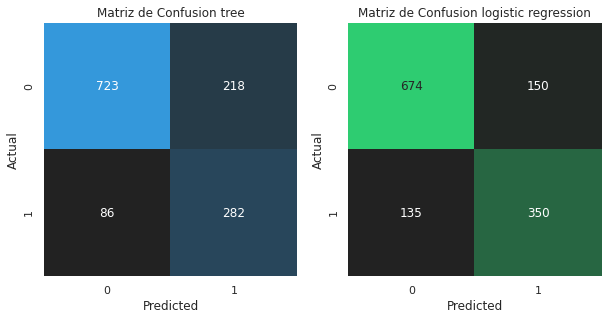

In [0]:
mat1 = confusion_matrix(res.actual, res.predicted[0,:])
mat2 = confusion_matrix(res.actual, res.predicted[1,:])
cmap = sns.dark_palette("#3498db", as_cmap=True)
cmap2 = sns.dark_palette("#2ecc71", as_cmap=True)
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=.2)
fig.set_size_inches(10,20)
sns.heatmap(mat1.T, square=True, annot=True, fmt='d', ax=ax,
            cbar=False, cmap=cmap)
sns.heatmap(mat2.T, square=True, annot=True, fmt='d', ax=ax2,
            cbar=False, cmap=cmap2)
ax.set_title("Matriz de Confusion "+learners[0].name)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
ax2.set_title("Matriz de Confusion "+learners[1].name)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual');